# Build a RNN model on Google Colab

In [ ]:
# Read the data set from google drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
cleaned_df=pd.read_csv('/content/drive/MyDrive/colabdata/aftertexblobIQR.csv', header=0)
cleaned_df.head()

Mounted at /content/drive/


,target,cleaned_text,polarity
0,0,upset update facebook texting might cry result...,0.000
1,0,behaving mad see,-0.625
2,0,need hug,0.000
3,0,nope,0.000
4,0,que muera,0.000


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

pd.set_option('max_colwidth',150)

In [ ]:
# Confirm the labels
cleaned_df.groupby('target').count()

,cleaned_text,polarity
target,,
0,604516,604516
1,443066,443066


In [ ]:
from sklearn.model_selection import train_test_split
# Split data into train and test set = 80:20
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['cleaned_text'],
                                                    cleaned_df['target'], test_size=0.2)

In [ ]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(tokenizer.word_index)+1

print(f'Vocabulary size: {vocab_size}')
print('\nExample:\n')
print(f'Sentence:\n{X_train.iloc[6]}')
print(f'\nAfter tokenizing :\n{X_train_seq[6]}')
print(f'The maximum length of an individual seq: {max([len(i)] for i in X_train_seq)}')

Vocabulary size: 171532

Example:

Sentence:
going away party

After tokenizing :
[11, 138, 209]
The maximum length of an individual seq: [111]


In [ ]:
# Pad the sequences so each sequence is the same length, equal the the longest one
X_train_seq_padded = pad_sequences(X_train_seq, 111)
X_test_seq_padded = pad_sequences(X_test_seq, 111)

print(f'\nAfter padding :\n{X_train_seq_padded[6]}')


After padding :
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  11 138 209]


In [ ]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [ ]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          5489024   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,498,433
Trainable params: 5,498,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [ ]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=5,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/5
26190/26190 [==============================] - 2874s 110ms/step - loss: 0.1452 - accuracy: 0.9366 - precision_m: 0.9203 - recall_m: 0.9181 - val_loss: 0.0811 - val_accuracy: 0.9635 - val_precision_m: 0.9555 - val_recall_m: 0.9580
Epoch 2/5
26190/26190 [==============================] - 2865s 109ms/step - loss: 0.0698 - accuracy: 0.9697 - precision_m: 0.9641 - recall_m: 0.9645 - val_loss: 0.0847 - val_accuracy: 0.9629 - val_precision_m: 0.9683 - val_recall_m: 0.9427
Epoch 3/5
26190/26190 [==============================] - 2829s 108ms/step - loss: 0.0545 - accuracy: 0.9771 - precision_m: 0.9730 - recall_m: 0.9729 - val_loss: 0.0846 - val_accuracy: 0.9636 - val_precision_m: 0.9572 - val_recall_m: 0.9566
Epoch 4/5
26190/26190 [==============================] - 2823s 108ms/step - loss: 0.0431 - accuracy: 0.9822 - precision_m: 0.9792 - recall_m: 0.9786 - val_loss: 0.0934 - val_accuracy: 0.9617 - val_precision_m: 0.9434 - val_recall_m: 0.9673
Epoch 5/5
26190/26190 [=================

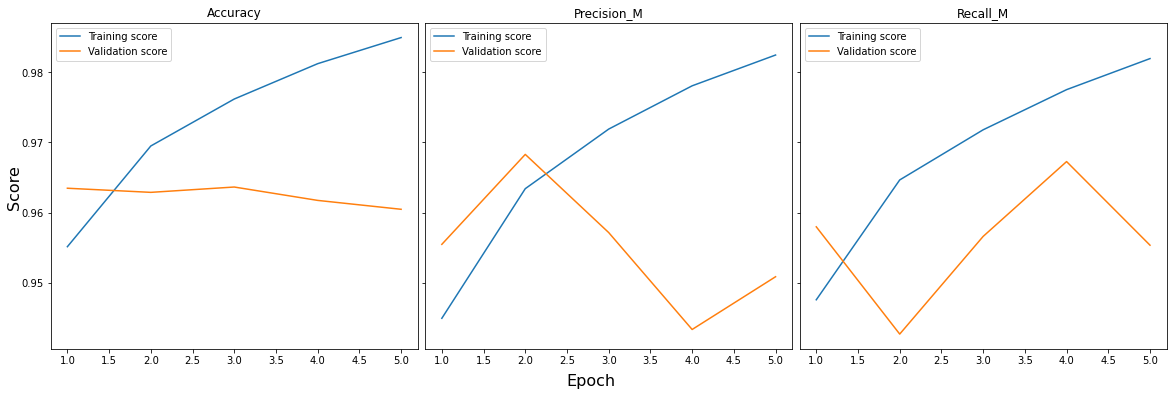

In [ ]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
m = ['accuracy', 'precision_m', 'recall_m']
for i in m:
    acc = history.history[i]
    val_acc = history.history[f'val_{i}']
    epochs = range(1, len(acc) + 1)

    axs[m.index(i)].plot(epochs, acc, label='Training score')
    axs[m.index(i)].plot(epochs, val_acc, label='Validation score')
    axs[m.index(i)].set_title(f'{i.title()}')
    axs[m.index(i)].legend()

fig.text(0.5, 0.05, 'Epoch', va='center', ha='center', fontsize=16)
fig.text(0.1, 0.5, 'Score', va='center', ha='center', rotation='vertical', fontsize=16)
fig.subplots_adjust(wspace=0.02)


In [ ]:
# train_acc = model.evaluate(X_train_seq_padded, y_train, verbose=0)
# test_acc = model.evaluate(X_test_seq_padded, y_test, verbose=0)
print("The model's metrics:")
print('          ', model.metrics_names)
print(f'Train set: {train_acc}')
print(f'Test set: {test_acc}')

The model's metrics:
           ['loss', 'accuracy', 'precision_m', 'recall_m']
Train set: [0.026314986869692802, 0.9899984002113342, 0.9874837398529053, 0.9889148473739624]
Test set: [0.09727223962545395, 0.9604805111885071, 0.950878381729126, 0.9553683400154114]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

predict_train = np.round(model.predict(X_train_seq_padded)).astype(int)
predict_test = np.round(model.predict(X_test_seq_padded)).astype(int)
print(f'Train accuracy: {accuracy_score(y_train, predict_train): .4f}')
print(f'Test accuracy:  {accuracy_score(y_test, predict_test): .4f}')



Train accuracy:  0.9900
Test accuracy:   0.9605


Confusion matrix, without normalization
[[116889   4339]
 [  3941  84348]]


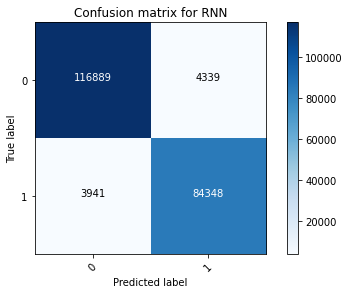

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, predict_test)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=[0,1],
                      title='Confusion matrix for RNN')

### Save the model to google drive

In [ ]:
import os
import datetime
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  
  modeldir = os.path.join('/content/drive/My Drive/colabdata/save_models/',
                          datetime.datetime.now().strftime('%Y%m%d'))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f'Saving model to: {model_path}...')
  model.save(model_path)
  return model_path

  
save_model(model, suffix='rnn')

Saving model to: /content/drive/My Drive/colabdata/save_models/20210330-rnn.h5...


'/content/drive/My Drive/colabdata/save_models/20210330-rnn.h5'

In [ ]:
import os
import datetime


# Create a function to save a model
def save_model_joblib(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  import joblib
  modeldir = os.path.join('/content/drive/My Drive/colabdata/save_models/',
                          datetime.datetime.now().strftime('%Y%m%d'))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f'Saving model to: {model_path}...')
  joblib.dump(model, model_path)
  return model_path

  
save_model_joblib(tokenizer, suffix='rnn_joblib')

Saving model to: /content/drive/My Drive/colabdata/save_models/20210330-rnn_joblib.h5...


'/content/drive/My Drive/colabdata/save_models/20210330-rnn_joblib.h5'